В этой статье, состоящей из нескольких частей, я постараюсь описать взаимосвязь всего машинного обучения с байесовским выводом и его приближениями: методами апостериорного максимума, максимума правдоподобия, имитацией отжига и вариационным выводом.

Рассмотрим, как применение этих методов порождает типичные для машинного обучения понятия, такие как среднеквадратичное отклонение, стохастический градиентный спуск, регуляризация, подбор архитектуры и гиперпараметров, кросс-валидация и ансамблирование. Также поговорим о фундаментальной роли априорных гипотез в машинном обучении.

Бывало ли у вас такое, что разбираясь в некой сложной области вам сначала не удается систематизировать в голове всю имеющуюся информацию, а затем вы что-то узнаете или догадываетесь, и пазл внезапно складывается в стройную и непротиворечивую картину? Именно такую роль может сыграть понимание байесовского вывода в машинном обучении.

Здесь, правда, есть опасность догматизации полученной теории, следствием чего может являться ограниченность мышления. Если теория красива, обоснованна и непротиворечива, то это еще не означает, что она единственно верна, и даже изучив теорию байесовского вывода, важно сохранить способность мыслить за ее пределами.

Как писал Пьер-Симон Лаплас в начале XIX века, "теория вероятностей - это здравый смысл, выраженный в вычислениях". Поэтому создавать и обучать модели машинного обучения можно и не опираясь на теорию вероятностей и байесовский вывод. Просто с их изучением то, что раньше казалось просто здравым смыслом, приобретает большую строгость и обоснования, вследствие чего становится легче понимать и улучшать алгоритмы, а также понимать научные статьи.

Кому-то мое изложение может показаться затянутым и излишне теоретизированным. Дело в том, что я ставил перед собой задачу рассказать все максимально детально, не упустив ничего важного. Теория вероятностей и статистический вывод - это не простые области, и еще сильнее сокращая изложение можно усложить понимание, так как читателю придется додумывать пропущенные детали.

Статья дополнена приложением с описанием некоторых понятий, а также обзором литературных источников.

## Машинное обучение и статистический вывод

Статистический вывод (оценка параметров и проверка гипотез) часто включается в курсы машинного обучения. Но многими он воспринимается лишь как досадная заноза, которая только отнимает время и далее нигде не используется. Однако машинное обучение и статистический вывод тесно связаны и решают почти одну и ту же задачу.

- **Машинное обучение** заключается в написании и применении алгоритмов, которые обучаются на данных, автоматически выводя общие закономерности из частных примеров. 
- **Статистический вывод** заключается в оценке параметров распределений и проверке гипотез на основе наблюдений, то есть опять-таки в получении общих выводов из частных примеров.

Процесс выведения общих правил из частных примеров называется обобщением (*generalization*), или [индуктивным выводом](https://plato.stanford.edu/entries/logic-inductive/) (*inductive inference*). Чем же тогда отличаются эти два раздела науки? Граница между ними довольно расплывчата. Вообще говоря, большую часть машинного обучения можно считать статистическим выводом, что мы более формально рассмотрим в дальнейшем. Однако в повседневной терминологии между ними есть некоторые различия. В машинном обучение как правило используются более сложные модели, тогда как в традиционной статистике модели проще, но больше внимания уделяется оценке неуверенности в найденных значениях параметров (*рис. 1*).

<img src="assets/inference.png" width="600" align="center">

<center><i>Рис. 1. Модели индуктивного вывода.</i></center>

Сложность модели обычно описывается количеством неизвестных параметров. При проверке гипотез неизвестный параметр всего один (бинарный): верна ли гипотеза. Промежуточным звеном по количеству параметров являются линейные модели. В нейронной сети каждый вес является параметром, и больше всего параметров (миллионы и даже миллиарды) в моделях компьютерного зрения, обработки текста и звука.

Чтобы еще лучше понять различия между машинным обучением и традиционной статистикой, рассмотрим три основных шага, из которых как правило состоит индуктивный вывод:

1. Различные преобразования входных данных, отбор признаков и выбор модели. Модель (статистическая модель или модель машинного обучения) является неким упрощением изучаемого распределения или зависимости.
2. Подбор параметров модели на основе данных. Этот шаг выполняется либо с помощью оптимизации (в машинном обучении), либо по аналитическим формулам (в статистике).
3. Оценка качества (валидация) полученной модели. Обычно шаги 1-2 повторяются несколько раз, и в результате мы получаем несколько обученных моделей, среди которых на шаге 3 выбираем наилучшую.

Важно то, что первый и третий шаги выполняются вручную, тогда как второй шаг выполняется автоматически (за исключением autoML-систем). В традиционной статистике модели обычно простые, но при этом большая часть работы перекладывается на первый и третий шаги. В машинном обучении, увеличивая количество неизвестных параметров, мы перекладываем большую часть работы на второй шаг, выполняемый автоматически. Поэтому с точки зрения инженера машинное обучение в целом не сложнее, а иногда и проще традиционной статистики.

## Вероятностные модели классификации и регрессии

### Регрессия, классификация и промежуточные варианты

В задачах классификации и регрессии требуется преобразовать входные данные в выходные. При этом в регрессии целевой признак количественный, в классификации - категориальный, то есть тип задачи определяется типом целевого признака.

Данная статья уже подразумевает знакомство читателя с этими двумя типами признаков (см. раздел "Пререквизиты"), но все же давайте немного поговорим о них. Главное отличие категориального от количественного признака заключается не столько в его типе (*int* или *float*), сколько в предполагаемой метрике сходства на множестве его значений:

- В *количественном признаке* чем больше модуль разности между двумя значениями, тем сильнее они непохожи друг на друга. Скажем, предсказать значение 2 вместо 1 будет в меньшей степени ошибкой, чем предсказать 10 вместо 1.
- В *категориальном признаке* все значения, называемые классами, одинаково непохожи друг на друга. Например, предсказать 2-й класс вместо 1-го будет в той же степени ошибкой, что и предсказать 10-й класс вместо 1-го. При этом множество значений, как правило, дискретно и конечно.

Все остальные отличия в выборе способа моделирования (формата выходных данных, функции потерь и метрики качества) обусловлены именно описанными выше отличиями в типе целевого признака. Вообще при желании задачу классификации можно решать как регрессию, напрямую предсказывая номер класса и округляя его до целого числа. Регрессию, наоборот, можно свести к классификации, выполнив дискретизацию множества значений целевого признака. Такие модели кое-как обучатся, но чаще всего их качество на валидации будет существенно ниже.

Бывают и такие случаи, когда целевой признак на первый вгляд является категориальным, но на деле некоторые классы могут быть ближе друг к другу, чем другие. Скажем, в классификации животных предсказать овчарку вместо лабрадора является в меньшей степени ошибкой, чем предсказать бегемота вместо лабрадора. Это означает, что на множестве значений целевого признака есть какая-то нетривиальная метрика сходства, и желательно ее учесть при выборе способа моделирования.

Будет ли это по прежнему задачей классификации? Сложно сказать. Базовые понятия "классификации" и "регрессии" не покрывают все разнообразие промежуточных вариантов (так же как есть промежуточные варианты между молотком, топором и другими инструментами). Важно лишь понять, что при выборе формата выходных данных и функции потерь нужно учитывать метрику сходства на множестве значений целевого признака. Это один из способов внесения в модель априорной (известной или предполагаемой заранее) информации, к чему мы будем еще не раз возвращаться.

### Вероятностное моделирование

В задачах классификации и регрессии (и многих других задачах) требуется найти зависимость между исходными данными $X$ и целевыми данными $Y$ в виде функции $f: X \to Y$. Обычно модель имеет параметры, которые подбираются в ходе обучения, поэтому модель можно записывать как функцию от входных данных и параметров: $f(x, \theta)$.

Общая идея вероятностного моделирования заключается в том, что вместо одного числа модель должна предсказывать *распределение вероятностей на множестве $Y$ при заданном значении $x \in X$*. В теории вероятностей это называется условным распределением (см. раздел 1 приложения) и записывается как $p(y|X=x)$ или просто $p(y|x)$. Поскольку модель имеет параметры, то вероятностную модель записывают как $p(y|x, \theta)$

Таким образом мы позволим модели "сомневаться" в предсказании. Выполнив такой переход, мы ничего не теряем: распределение вероятностей $p(y|x, \theta)$ является более выразительным, чем точечная оценка $f(x, \theta)$. Зато мы получаем важное преимущество. Величина $p(y|x, \theta)$ определена для всех $y \in Y$, и чем большую вероятность модель назначает верному $y$ (на обучающих данных), тем меньше ошибка модели. Так мы естественным образом можем задать функцию потерь (далее рассмотрим на примерах).

Поговорим еще немного о том, что такое модель в принципе. *Модель* - это некое приближение реальности. Она может быть не идеально точна, но если после обучения нас устраивает ее точность, то мы можем извлечь из нее пользу. Вся наука и инженерия основаны на моделях как упрощениях наблюдаемых явлений. *Статистической моделью* называется некое множество распределений. *Вводя статистическую модель мы предполагаем, что среди этих распределений есть то, которое с хорошей точностью описывает наблюдаемые данные.* Задача - найти это распределение, этим и занимается статистический вывод. Впрочем, в каких-то случаях наше предположение может быть неверным, то есть модель может быть выбрана неудачно.

### Распределение данных

Понятия *распределения данных* является ключевым в статистическом подходе к машинному обучению. Как правило считается, что обучающие и тестовые данные берутся из одного и того же совместного распределения $p(x, y)$, называемого распределением данных, или *генеральной совокупностью*. Исходя из базовых законов теории вероятностей, можно записать следующую формулу (см. также раздел 1 приложения):

$p(x, y) = p(y|x)p(x) \tag{1}$

Модели, которые моделируют $p(y|x)$, то есть ищут некое приближение для истинного $p(y|x)$, называются *дискриминативными моделями*.  Важная особенность дискриминативных моделей в том, что они не моделируют вероятность входных данных $p(x)$, то есть дискриминативная модель не может оценить то, насколько реалистичны входные данные. Для этой задачи используются *генеративные модели*, которые мы будем рассматривать в дальнейшем.

Говоря о распределении $p(x)$ или $p(x, y)$, мы условно предполагаем наличие некоего бесконечного генератора примеров $(x, y)$, из которого взяты обучающая и тестовая выборка. Конечно, генеральная совокупность данных - это условность, и вопрос ее близости к истине довольно философский. Обычно мы имеем лишь конечную выборку данных, добытую тем или иным способом, но не имеем строгого определения для $p(x, y)$. Но в целом мы считаем, что $p(x, y)$ наиболее велико для "типичных" пар $(x, y)$, и равно нулю для невозможных пар (в которых либо $p(x)=0$, либо $p(y|x)=0$.

Например, пусть мы имеем датасет из объявлений о продаже автомобилей. Для нашего датасета верно, например, следующее:

- Количество авто "Lada Granta" превосходит количество авто "Москвич-412"
- Количество авто "Победа" с двигателем мощностью 500 л. с. равно нулю

Тогда мы можем считать датасет выборкой из распределения, в котором для $p(x)$ верно следующее:

- $p(x|\text{марка}(x) = \text{"Lada Granta"}) > p(x|\text{марка}(x) = \text{"Москвич-412"})$
- $p(x|\text{марка}(x) = \text{"Победа"}\ \&\ \text{мощность}(x) \approx \text{"500 л. с."}) \approx 0$

Статистический подход к машинному обучению не лишен недостатков. Часто бывают ситуации, когда обучающее распределение $p(x, y)$ недостаточно разнообразно, содержит паразитные корреляции, и избавиться от этого иногда не представляется возможным. Отсюда возникают проблемы сдвига и утечки данных. Подробно и с большим количеством примеров я рассказывал об этих проблемах в статье "[Проблемы современного машинного обучения](https://habr.com/ru/company/ods/blog/651103/)".

### Вероятностная модель регрессии

Часто регрессию определяют как "одностороннюю стохастическую зависимость". Стохастичность означает, что целевой признак зависит от еще чего-то кроме исходных признаков, а значит предсказать его можно лишь приблизительно. Поэтому вероятностная постановка в задаче регрессии более естественна, чем точечная оценка $f(x)$.

Рассмотрим, как выполнить переход от точечной оценки к вероятностной. В точечной оценке модель
В вероятностной постановке задачи модель по прежнему предсказывает число $f(x, \theta)$, но теперь это число считается мат. ожиданием нормального распределения с некой фиксированной дисперсией $\sigma^2$ (о нормальном распределении см. раздел 2 приложения). Это, впрочем, не единственный способ, но самый распространенный. Запишем формально такую модель:

$p(y|x, \theta) = \mathcal{N}(y; f(x, \theta), \sigma^2) \tag{2}$

Поскольку переменная $y$ непрерывна, то $p(y|x, \theta)$ - это не вероятность, а плотность вероятности. Формулу $(2)$ можно записать иначе. Ниже приведенная запись читается как "$y$ распределен нормально с мат. ожиданием $f(x, \theta)$ и дисперсией $\sigma^2$":

$y \sim \mathcal{N}(f(x, \theta), \sigma^2) \tag{3}$

Кстати, нам ничего не мешает сделать $\sigma^2$ не константой, а функцией от входных данных и параметров. Тогда модель будет выдавать сразу 2 числа: мат. ожидание $y$ и дисперсию $y$ (степень уверенности в предсказании). Однако чаще всего оценивают только мат. ожидание.

Таким образом, вводя вероятностную модель регрессии $(3)$ мы предполагаем, что *существуют такие значения параметров $\theta$, что модель $(3)$ хорошо решает поставленную задачу* оценки $y$ по $x$. Поиск этих значений параметров и называется обучением.

Почему мы берем именно нормальное распределение? По центральной предельной теореме если некая случайная величина $y$ является суммой множества случайных факторов, и каждый фактор вносит исчезающе малый вклад в сумму, то величина $y$ распределена приблизительно нормально. Моделируя $p(y|x)$ нормальным распределением, мы делаем предположение, что все основные факторы содержатся в исходных данных $x$, а все остальные факторы несущественны, и поэтому *$p(y|x)$ можно промоделировать нормальным распределением*. Но бывают ситуации, когда это явно не так, и тогда используются другие модели (например, модели со скрытыми переменными, обучаемые EM-алгоритмом).

Впрочем, такими рассуждениями руководствуются не всегда. Иногда форму распределения выбирают из соображений легкости оптимизации функции потерь (далее мы увидим, как форма распределения преобразуется в формулу для функции потерь) или же просто исходя из того, как принято делать.

### Обучение вероятностной модели регрессии

Пусть мы имеем обучающий набор данных $X = \{x_i, y_i\}_{i=1}^N$. Этот набор мы рассматриваем как выборку из совместного распределения $p(x, y)$. Если мы зафиксируем некие значения параметров $\theta$, то $i$-й пример, согласно нашей модели, будет иметь плотность вероятности $p(y_i|x_i, \theta)$. Поскольку все примеры в выборке независимы, то общая плотность вероятности всей выборки равна произведению плотностей вероятностей всех примеров:

$\begin{equation}
\begin{split}
p(X|\theta) & = \prod\limits_{i=1}^N p(y_i|x_i, \theta) \\
 & = \prod\limits_{i=1}^N \mathcal{N}(y_i; f(x_i, \theta), \sigma) \\
 & = \cfrac{1}{(\sigma \sqrt{2 \pi})^N} \prod\limits_{i=1}^N \exp \bigg( -\cfrac{(y_i - f(x_i, \theta))^2}{2 \sigma^2} \bigg)
\end{split} 
\end{equation} \tag{4}$

Первое преобразование выполнено исходя из формулы $(2)$, второе - по формуле для плотности вероятности нормального распределения. Рассмотрим полученное выражение. Большая ошибка в $i$-м примере означает, что $f(x_i, \theta)$ далеко от $y_i$, и следовательно $i$-й множитель получается очень близким к нулю. Отсюда, чем больше в выборке примеров, предсказанных с большой ошибкой, тем меньше $p(X|\theta)$.

*Метод максимума правдоподобия* (maximum likelihood estimation, MLE) заключается в том, что мы ищем такие параметры $\theta$, при которых $p(X|\theta)$ (правдоподобие) достигает максимума. Это соответствует здравому смыслу. Выборка $X$ состоит из реальных пар исходные + целевые данные, и если модель назначает этим данным низкую вероятность, то вероятно она неверна.

Поиск максимума функции $p(X|\theta)$ эквивалентен поиску максимума ее логарифма, а логарифм произведения равен как сумма логарифмов множителей. Также по традиции к функции добавляется минус и ищется ее минимум:

$\begin{equation}
\begin{split}
\theta^{ML} & = \underset{\theta}{\text{argmax}} \prod\limits_{i=1}^N p(y_i|x_i, \theta) \\
& = \underset{\theta}{\text{argmin}} \Big( -\ln\prod\limits_{i=1}^N p(y_i|x_i, \theta) \Big) \\
& = \underset{\theta}{\text{argmin}} \Big( -\sum\limits_{i=1}^N \ln p(y_i|x_i, \theta) \Big)
\end{split} 
\end{equation} \tag{5}$

Формула $(5)$ подходит для любой дискриминативной модели. Вообще мы могли бы и не брать логарифм, но тогда пришлось бы искать максимум произведения многих сомножителей, что неудобно и может привести к большим погрешностям вычислений. Теперь нам осталось подставить в формулу $(5)$ выражение $p(y_i|x_i, \theta)$ для нашей модели, взяв его из формулы $(4)$.

$\begin{equation}
\begin{split}
\theta^{ML} & = \underset{\theta}{\text{argmin}} \bigg( -\sum\limits_{i=1}^N \ln \exp \bigg( -\cfrac{(y_i - f(x_i, \theta))^2}{2 \sigma^2} \bigg) \bigg) \\
 & = \underset{\theta}{\text{argmin}} \sum\limits_{i=1}^N \bigg( \cfrac{(y_i - f(x_i, \theta))^2}{2 \sigma^2} \bigg) \\
 & = \underset{\theta}{\text{argmin}} \sum\limits_{i=1}^N \big(y_i - f(x_i, \theta) \big)^2
\end{split} 
\end{equation} \tag{6}$

В выражении $(6)$ мы получили логарифм экспоненты, и они взаимно сократились. Затем мы избавились от $2 \sigma^2$, так как это константа, не влияющая на положение максимума функции. Отсюда получается, что оптимальные параметры для модели $(2)$ можно найти, *минимизировав среднеквадратичное отклонение* (mean, squared error, MSE) предсказаний модели от верных ответов на обучающей выборке, что соответствует здравому смыслу.

Вспомним, что изначально в модели регрессии мы считали $\sigma^2$ константой, для которой выбрано произвольное значение. Теперь выясняется, что константа $\sigma^2$ не влияет на оптимальные параметры $\theta^{ML}$, поэтому ее значение не играет роли.

Важно отметить, что применение теории вероятностей и переход к вероятностной модели регрессии по формуле $(2)$ никак не избавляет от переобучения, которое может быть следствием подгонки модели под обучающую выборку (о переобучении мы еще поговорим в дальнейшем). По сути, все, что мы получили - *теоретическое обоснование применения MSE как функции потерь в регрессии*. Казалось бы, стоило ли оно того? Это был лишь базовый пример. Самолет братьев Райт тоже не принес особой пользы, пролетев свои 30 метров.

Таким образом, промоделировав $p(y|x, \theta)$ нормальным распределением и применив метод максимума правдоподобия мы получаем, что нужно минимизировать среднеквадратичное отклонение. Если же вместо нормального распределения мы выберем распределение Лапласа, то придем к тому, что нужно минимизировать среднее абсолютное отклонение (mean absolute error, MAE), то есть модуль разности верного ответа и предсказания. В целом, функция потерь равна минус логарифму плотности вероятности для выбранного распределения (*рис. 2*).

<img src="assets/dist.png" width="600" align="center">

<center><i>Рис. 2. В верхнем ряду: преобразовав нормальное распределение в логарифмическую шкалу по вертикальной оси, мы получаем параболу с направленными вниз ветвями; взяв ее со знаком минус, получаем функцию потерь MSE. В нижнем ряду: выполнив аналогичные действия с распределением Лапласа, получаем функцию потерь MAE. В среднем ряду: скомбинировав нормальное распределение с хвостами от распределения Лапласа, получаем функцию потерь Хьюбера.</i></center>

Многие распределения, встречающиеся в реальном мире, близки к нормальному распределению (за счет центральной предельной теоремы), но как правило имеют более "тяжелые хвосты", то есть большую вероятность встретить крайние значения. Скажем, рост или вес человека в популяции распределен приблизительно нормально, но рекордсмены по росту или весу (в ту или иную сторону) встречаются намного чаще, чем если бы распределение было строго нормальным. Поэтому разумно было бы моделировать $p(y|x, \theta)$ распределением, похожим на нормальное, но с более тяжелыми хвостами. Распределение Лапласа имеет более тяжелые хвосты, чем нормальное распределение, поэтому мы можем "склеить" эти два распределения, взяв центральную часть от нормального распределения и хвосты от распределения Лапласа. Если далее вывести функцию потерь по формуле $(5)$ (как минус логарифм плотности вероятности), то получим часто используемую функцию потерь Хьюбера. Эта функция потерь равна квадрату отклонения, если модуль отклонения меньше $\delta$ (это гиперпараметр), и равна модулю отклонения, если он больше $\delta$. Функция потерь Хьюбера не так сильно "штрафует" большие выбросы, как MSE:

$\text{Huber}(y_{\text{true}}, y_{\text{pred}}) = 
\begin{cases}
\frac{1}{2} (y_{\text{true}} - y_{\text{pred}})^2,& \text{if } |y_{\text{true}} - y_{\text{pred}}| \leq \delta\\
\delta (|y_{\text{true}} - y_{\text{pred}}| - \frac{1}{2} \delta),& \text{otherwise}
\end{cases} \tag{7}$

### Регрессия с оценкой уверенности (дополнительный раздел)

В этом разделе мы рассмотрим другой пример вероятностного моделирования в задаче регрессии. Этот раздел не повлияет на понимание дальнейшего материала, поэтому при желании его можно пропустить. В нем мы попробуем промоделировать одновременно мат. ожидание и логарифм дисперсии целевой переменной. Затем попробуем этот метод на практике (в виде кода и эксперимента) и поговорим о полученных выводах.

Выберем модель следующим образом (сравните с моделью $(2)$):

$p(y|x, \theta) = \mathcal{N}(y; f_1(x, \theta), \exp(f_2(x, \theta))) \tag{8}$

В качестве функций $f_1(x, \theta)$ и $f_2(x, \theta)$ можно взять, например, нейронную сеть с двумя выходными нейронами. Для обучения модели снова будем использовать метод максимума правдоподобия, в котором функция потерь рассчитывается по формуле $(5)$, где $-\ln p(y_i|x_i, \theta)$ - функция потерь на каждом обучающем примере. Распишем ее для модели $(8)$ с использованием формулы нормального распределения:

$\begin{equation}
\begin{split}
-\ln p(y_i|x_i, \theta) & = -\ln \mathcal{N}(y_i; f_1(x_i, \theta), \exp(f_2(x_i, \theta))) \\
& = -\ln \Bigg( \cfrac{1}{\sqrt{2 \pi \exp(f_2(x_i, \theta))}} \exp \bigg( -\cfrac{(y_i - f_1(x_i, \theta))^2}{2 \exp(f_2(x, \theta))} \bigg) \Bigg) \\
& = \cfrac{(y_i - f_1(x_i, \theta))^2}{2 \exp(f_2(x, \theta))} + \frac{1}{2} f_2(x_i, \theta) + \frac{1}{2} \ln {2 \pi}
\end{split} 
\end{equation} \tag{9}$

Мы получили выражение для функции потерь. Последнее слагаемое можно удалить, так как оно является константой. В формуле $(9)$ мы снова видим среднеквадратичное отклонение, но теперь к нему добавляется дополнительный множитель и дополнительное слагаемое. В формуле $(8)$ мы позволили модели оценивать дисперсию $f_2(x_i, \theta)$, то есть степень уверенности предсказания на каждом примере. Высокое значение предсказанной дисперсии повышает значение функции потерь за счет второго слагаемого, но при этом уменьшает вклад первого слагаемого, которое штрафует ошибку предсказания. Это дает модели некий компромисс: модель может предсказывать на каких-то примерах высокую дисперсию, уменьшая штраф от неточного предсказания самого значения на них (то есть мат. ожидания $y$).

Однако реализовав функцию потерь $(9)$ на практике, мы увидим, что точность модели несколько упадет по сравнению с моделью, предсказывающей лишь мат. ожидание (под точностью понимается MSE предсказания мат. ожидания на валидации). Таким образом, *точность предсказания мат. ожидания может падать*. Чтобы исправить эту проблему, мы можем перевзвесить слагаемые формулы $(9)$, добавив коэффициент меньше единицы перед вторым слагаемым, и тем самым повысив относительную важность корректного рассчета мат. ожидания.

Есть и еще один элегантный способ. Первый нейрон, который выдает мат. ожидание, мы можем обучать с помощью обычного среднеквадратичного отклонения, а второй нейрон, который выдает логарифм дисперсии, обучать по формуле $(9)$, при этом блокируя протекание градиента в первый нейрон. Тем самым мы добиваемся того, что предсказание дисперсии становится лишь дополнительной задачей, не влияющей на процесс обучения предсказанию мат. ожидания. В результате получится следующая формула для функции потерь:

$\text{Loss}(y, f_1(x, \theta), f_2(x, \theta)) = (y_i - f_1(x_i, \theta))^2 + \cfrac{(y_i - \text{StopGradient}(f_1(x_i, \theta)))^2}{2 \exp(f_2(x, \theta))} + \frac{1}{2} f_2(x_i, \theta) \tag{10}$

Проверим функции потерь $(9)$ и $(10)$ на практике, обучив модель на датасете California Housing, в котором нужно предсказывать цену недвижимости в разных районах Калифорнии, имея 8 исходных признаков.

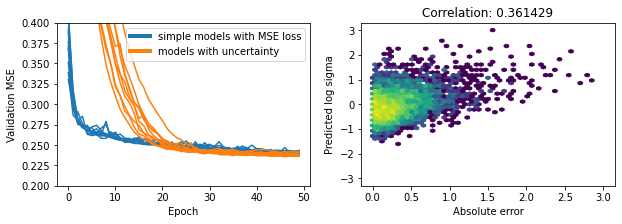

In [52]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# loss based on formulas (9) and (10)

def custom_loss(y_true, y_pred, stop_gradient=False, coef=0.2):
  y_true = tf.squeeze(y_true)
  mu, log_sigma = y_pred[:, 0], y_pred[:, 1]
  if not stop_gradient: #using balancing coef
    loss = (y_true - mu)**2 / 2 / tf.math.exp(log_sigma) + coef * log_sigma / 2
  else: #not using balancing coef, using stop_gradient
    loss = (y_true - mu)**2 + (y_true - tf.stop_gradient(mu))**2 \
                       / 2 / tf.math.exp(log_sigma) + log_sigma / 2
  return tf.math.reduce_mean(loss)

def custom_mse(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  mu, log_sigma = y_pred[:, 0], y_pred[:, 1]
  metrics = (y_true - mu)**2
  return tf.math.reduce_mean(metrics)

# downloading and preprocessing dataset
X, y = fetch_california_housing(return_X_y=True)
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train[:, None])[:, 0]
y_test = scaler.transform(y_test[:, None])[:, 0]

#training models

def train_simple_model(epochs=50, dropout=0.5):
  model = Sequential([
      layers.Dense(1000, 'relu'),
      layers.Dropout(dropout),
      layers.Dense(1)
  ])
  model.compile(loss='mse', optimizer=optimizers.Adam(InverseTimeDecay(1e-3, 1000, 2)))
  model.fit(X_train, y_train, validation_data=(X_test, y_test),
            batch_size=128, epochs=epochs, verbose=0)
  return model, model.history.history['val_loss']

def train_model_with_uncertainty(epochs=50, dropout=0.5):
  model = Sequential([
      layers.Dense(1000, 'relu'),
      layers.Dropout(dropout),
      layers.Dense(2)
  ])
  model.compile(loss=custom_loss, metrics=custom_mse,
                optimizer=optimizers.Adam(InverseTimeDecay(1e-3, 1000, 2)))
  model.fit(X_train, y_train, validation_data=(X_test, y_test),
            batch_size=128, epochs=epochs, verbose=0)
  return model, model.history.history['val_custom_mse']

n_tests = 10
simple = [train_simple_model() for i in range(n_tests)]
uncertainty = [train_model_with_uncertainty() for i in range(n_tests)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

from matplotlib.lines import Line2D
for model, history in simple:
  ax1.plot(history, color='C0', label='simple models with MSE loss')
for model, history in uncertainty:
  ax1.plot(history, color='C1', label='models with uncertainty')
ax1.set_ylim(0.2, 0.4)
ax1.legend([Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='C1', lw=4)],
           ['simple models with MSE loss', 'models with uncertainty'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation MSE')

model, _ = uncertainty[0]
preds_test = model.predict(X_test)
ax2.hexbin(np.abs(preds_test[:, 0] - y_test),
           preds_test[:, 1], bins='log', extent=(0, 3, -3, 3), gridsize=50)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Predicted log sigma')
corr = pearsonr(np.abs(preds_test[:, 0] - y_test), preds_test[:, 1])[0]
ax2.set_title(f'Correlation: {corr:g}')

plt.show()

<center><i>Рис. 3. Слева - результаты обучения моделей с оценкой неуверенности, справа - корреляция неуверенности с ошибкой предсказания на валидационной выборке.</i></center>

Мы обучили 10 моделей с простой функцией потерь MSE и еще 10 моделей с оценкой неуверенности, обученных с помощью формулы $(9)$. На первом графике (*рис. 3*, слева) видно, что наши модели превысили по качеству обычные модели, обучаемые с функцией потерь MSE. Возможно это связано с тем, что снижается переобучение модели на выбросах, так как в областях с частыми выбросами предсказывается высокое значение неуверенности, что смягчает ошибку предсказания мат. ожидания в этих областях, уменьшая множитель при первом слагаемом в формуле $(9)$.

На втором графике (*рис. 3*, справа) возьмем одну из моделей с оценкой неуверенности, и рассмотрим корреляцию реальной ошибки предсказания  и предсказанного логарифма дисперсии (на валидационной выборке). Положительная корреляция говорит о том, что модель в какой-то степени справляется с задачей оценки собственной уверенности в предсказании.

Как правило, при минимизации одновременно нескольких слагаемых в функции потерь обучение становится более нестабильным, и нужен более низкий learning rate. Поэтому результат проведенного эксперимента зависит от `random_state` при делении на обучающую и валидационную выборку. В некоторых случаях процесс обучения моделей с оценкой неуверенности расходится (например, при `random_state=0`). Но как правило он все же сходится, причем к более высокой точности, чем в обычных моделях, обучаемые через MSE.

TODO

------------